# 1.Imports

In [1]:
import os
import numpy as np
import tensorflow as tf
from transformers import AutoModel, AutoImageProcessor
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from tqdm import tqdm
from PIL import Image
from tensorflow.keras import layers, models

In [2]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_memory_growth(gpus[0], True)
    except:
        pass

In [3]:
# 定义全局参数    Определение глобальных параметров
IMG_SIZE = (224, 224)  # 输入图像尺寸（与ConvNeXT预训练要求一致）    Размер входного изображения (соответствует требованиям предобученной модели ConvNeXT)
BATCH_SIZE = 128  # 批量大小    Размер пакета
SEED = 42  # 随机种子    Случайное семя

# 2.Data

In [4]:
# 设置数据路径    Установка пути к данным
train_path = r"C:\Users\lcf14\Desktop\homework\Machine_Learning_appli\fruits-360-original-size\Training"  # 训练数据路径    Путь к тренировочным данным
test_path = r"C:\Users\lcf14\Desktop\homework\Machine_Learning_appli\fruits-360-original-size\Validation"  # 测试数据路径    Путь к тестовым данным

In [5]:
# 数据加载与预处理    Загрузка и предварительная обработка данных
def load_data(data_path, max_per_class=None):
    """
    加载数据并将其转换为适合模型的格式。    Загрузка данных и их преобразование в формат, подходящий для модели.
    :param data_path: 数据集路径    Путь к набору данных
    :param max_per_class: 每个类别最多读取的样本数量    Максимальное количество образцов для каждого класса
    :return: 图片和标签的列表    Возвращает список изображений и меток
    """
    images, labels = [], []  
    class_names = os.listdir(data_path)  # 获取所有类别名称    Получение всех названий классов
    for label, class_name in enumerate(class_names):
        class_folder = os.path.join(data_path, class_name)  # 获取每个类别的文件夹路径    Получение пути к папке каждого класса
        image_files = os.listdir(class_folder)  # 获取类别中的所有图像文件    Получение всех изображений в классе
        if max_per_class:  # 限制每个类别读取的样本数    Ограничение количества образцов для каждого класса
            image_files = image_files[:max_per_class]
        for image_name in image_files:
            image_path = os.path.join(class_folder, image_name)  # 获取图像文件的完整路径    Получение полного пути к файлу изображения
            image = Image.open(image_path).convert("RGB")  # 确保为RGB格式    Убедитесь, что формат RGB
            images.append(image)
            labels.append(label)
    return images, np.array(labels), class_names

In [6]:
# 加载训练和测试数据    Загрузка тренировочных и тестовых данных
train_images, train_labels, class_names = load_data(train_path, max_per_class=None)  # 加载训练数据    Загрузка тренировочных данных
test_images, test_labels, _ = load_data(test_path, max_per_class=None)  # 加载测试数据    Загрузка тестовых данных

# 3.Backbone

In [7]:
# 加载预训练模型
#backbone = AutoModel.from_pretrained("facebook/convnext-base-224", output_hidden_states=False)
#processor = AutoImageProcessor.from_pretrained("facebook/convnext-base-224")

In [8]:
# 保存模型到本地 
#backbone.save_pretrained("./convnext-base-224_model") 
#processor.save_pretrained("./convnext-base-224_processor")

In [9]:
# 从本地加载模型    Загрузка модели локально
backbone = AutoModel.from_pretrained("./convnext-base-224_model", output_hidden_states=False)  # 从本地路径加载ConvNeXT模型    Загрузка модели ConvNeXT из локального пути
processor = AutoImageProcessor.from_pretrained("./convnext-base-224_processor")  # 从本地路径加载图像处理器    Загрузка процессора изображений из локального пути

# 4.Feature extraction

In [10]:
# 特征提取    Извлечение признаков
def extract_features(images, labels):
    """
    使用预训练模型提取图像特征。    Извлечение признаков изображений с использованием предобученной модели.
    :param images: 输入图像    Входные изображения
    :param labels: 输入标签    Входные метки
    :return: 提取的特征和对应的标签    Возвращает извлеченные признаки и соответствующие метки
    """
    import torch  # 确保使用 PyTorch    Убедитесь, что используется PyTorch
    features = []
    for image in tqdm(images):
        # 处理图像，并将图像大小设置为模型的预期输入    Обработка изображений и изменение их размера для соответствия входным данным модели
        processed = processor(image, return_tensors="pt", size={'shortest_edge': IMG_SIZE[0]})
        with torch.no_grad():
            # 提取特征，通常在最后一层全局池化层提取    Извлечение признаков, обычно из последнего слоя глобального пула
            output = backbone(**processed)
            features.append(output.pooler_output.numpy())  # 提取特征并保存    Извлечение признаков и сохранение
    return np.vstack(features), labels

In [11]:
train_features, train_labels = extract_features(train_images, train_labels)  # 提取训练数据特征和标签    Извлечение признаков и меток тренировочных данных
test_features, test_labels = extract_features(test_images, test_labels)  # 提取测试数据特征和标签    Извлечение признаков и меток тестовых данных

100%|██████████████████████████████████████████████████████████████████████████████| 3114/3114 [19:11<00:00,  2.70it/s]


# 5.Prepare train/test data

In [12]:
# 数据集划分与准备    Разделение и подготовка датасета
X_train, X_val, y_train, y_val = train_test_split(train_features, train_labels, test_size=0.2, random_state=SEED)  # 划分训练集和验证集    Разделение тренировочного и валидационного наборов данных
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(BATCH_SIZE).shuffle(1000, seed=SEED)  # 准备训练数据集    Подготовка тренировочного набора данных
val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val)).batch(BATCH_SIZE)  # 准备验证数据集    Подготовка валидационного набора данных
test_dataset = tf.data.Dataset.from_tensor_slices((test_features, test_labels)).batch(BATCH_SIZE)  # 准备测试数据集    Подготовка тестового набора данных

# 6.Build the model

In [13]:
# 构建分类器模型    Построение модели классификатора
model = models.Sequential([
    layers.Input(shape=(train_features.shape[1],)),  # 输入维度为特征向量的维度    Входное измерение соответствует размеру вектора признаков
    layers.Dense(128, activation="relu"),  # 一个全连接层    Полносвязный слой
    layers.Dense(len(class_names), activation="softmax")  # 输出类别数的概率向量    Выходной вектор вероятностей для числа классов
])

In [14]:
# 编译模型，使用Adam优化器和稀疏分类交叉熵损失    
# Компиляция модели с использованием оптимизатора Adam и функции потерь sparse_categorical_crossentropy
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

In [30]:
model.summary()  # 打印模型摘要    Вывод сводки модели

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 128)                 │         131,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 24)                  │           3,096 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 402,890 (1.54 MB)

 Trainable params: 134,296 (524.59 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 268,594 (1.02 MB)

# 7.Train the model

In [16]:
# 训练模型    Обучение модели
history = model.fit(train_dataset, validation_data=val_dataset, epochs=10)

Epoch 1/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.4784 - loss: 2.2009 - val_accuracy: 0.9134 - val_loss: 0.5822
Epoch 2/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9096 - loss: 0.4914 - val_accuracy: 0.9751 - val_loss: 0.2629
Epoch 3/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9766 - loss: 0.2406 - val_accuracy: 0.9952 - val_loss: 0.1530
Epoch 4/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9908 - loss: 0.1396 - val_accuracy: 0.9952 - val_loss: 0.0982
Epoch 5/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9974 - loss: 0.0952 - val_accuracy: 0.9992 - val_loss: 0.0670
Epoch 6/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9979 - loss: 0.0648 - val_accuracy: 0.9992 - val_loss: 0.0504
Epoch 7/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9997 - loss: 0.0477 - val_accuracy: 1.0000 - val_loss: 0.0381
Epoch 8/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9997 - loss: 0.0355 - val_accuracy: 1.0000 - val_loss:

# 8.Evaluation

In [17]:
# 模型评估 Оценка модели
test_loss, test_acc = model.evaluate(test_dataset)
print(f"Accuracy of test: {test_acc * 100:.2f}%")

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.0000 - loss: 0.0244
Accuracy of test: 100.00%


98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


<Figure size 4800x4800 with 0 Axes>

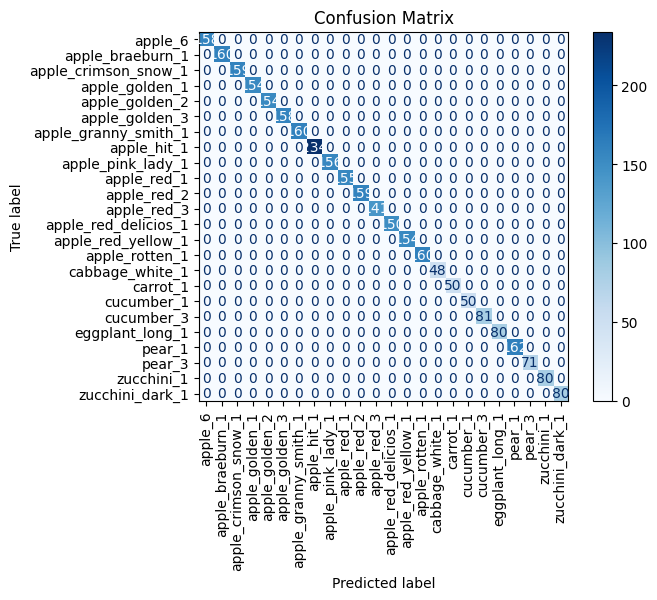

In [29]:
# 绘制混淆矩阵    Построение матрицы ошибок
pred_labels = np.argmax(model.predict(test_features), axis=1)  # 预测标签    Предсказание меток
cm = confusion_matrix(test_labels, pred_labels)  # 计算混淆矩阵    Вычисление матрицы ошибок
plt.figure(figsize=(48, 48))  # 设置图像大小
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)  # 创建混淆矩阵显示对象    Создание объекта для отображения матрицы ошибок
disp.plot(cmap=plt.cm.Blues, xticks_rotation="vertical")  # 绘制混淆矩阵，并设置颜色映射和x轴标签旋转角度    Построение матрицы ошибок с установкой цветовой схемы и угла поворота меток оси X
plt.title("Confusion Matrix")  # 设置图像标题    Установка заголовка изображения
plt.show()

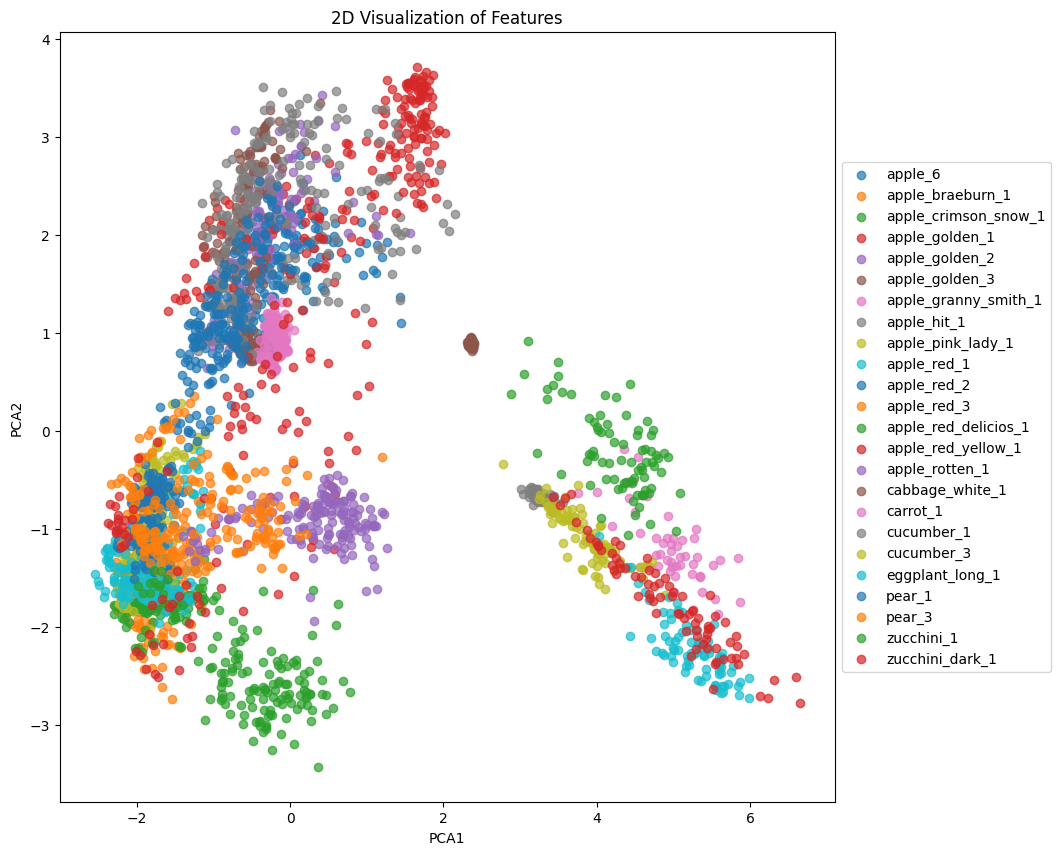

In [19]:
# 使用PCA进行特征降维并可视化    Использование PCA для уменьшения размерности признаков и их визуализация
pca = PCA(n_components=2)  # 初始化PCA，降维到2个主成分    Инициализация PCA для уменьшения размерности до 2 главных компонентов
reduced_features = pca.fit_transform(test_features)  # 适应并转换测试特征    Подгонка и преобразование тестовых признаков

plt.figure(figsize=(10, 10))  # 设置图像大小    Установка размера изображения
for label in np.unique(test_labels):
    plt.scatter(reduced_features[test_labels == label, 0],
                reduced_features[test_labels == label, 1],
                label=class_names[label], alpha=0.7)  # 绘制散点图    Построение диаграммы рассеяния
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))  # 设置图例位置    Установка положения легенды
plt.title("2D Visualization of Features")  # 设置图像标题    Установка заголовка изображения
plt.xlabel("PCA1")  # 设置X轴标签    Установка метки по оси X
plt.ylabel("PCA2")  # 设置Y轴标签    Установка метки по оси Y
plt.show()

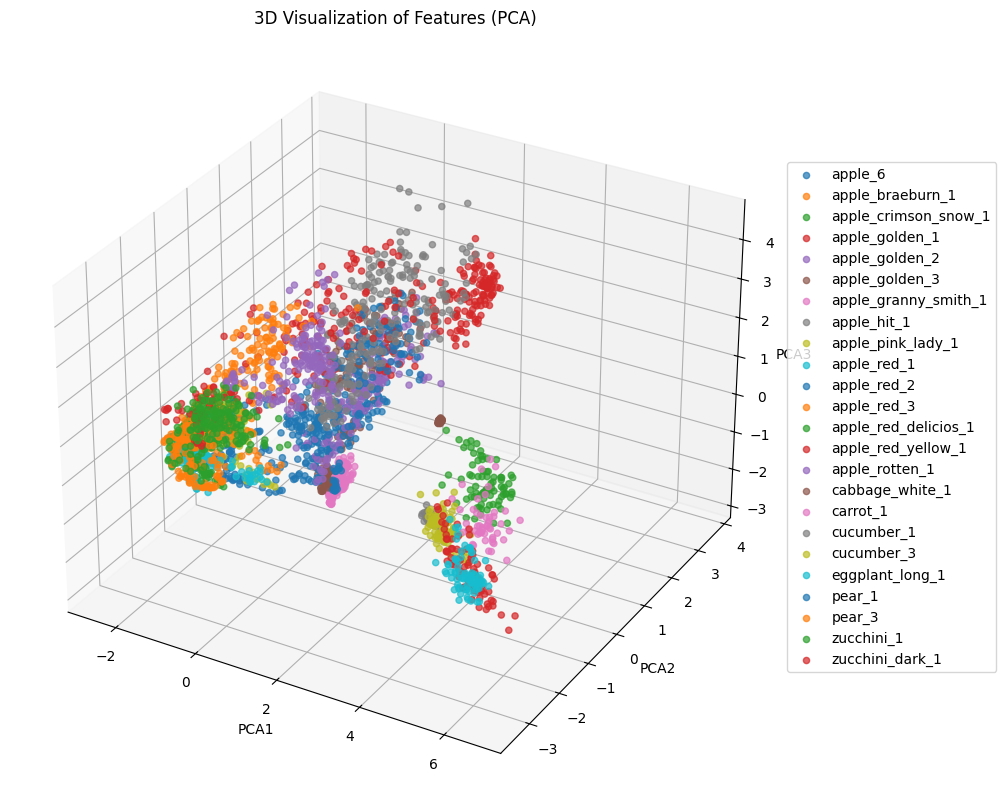

In [28]:
from mpl_toolkits.mplot3d import Axes3D  # 3D 绘图模块    Модуль для 3D графики

# 使用 PCA 降到 3 维    Применение PCA для уменьшения размерности до 3
pca = PCA(n_components=3)  # 初始化 PCA，降维到 3 个主成分    Инициализация PCA для уменьшения размерности до 3 главных компонентов
reduced_features_3d = pca.fit_transform(test_features)  # 适应并转换测试特征    Применение и преобразование тестовых признаков

# 3D 可视化    Визуализация в 3D
fig = plt.figure(figsize=(10, 10))  # 设置图像大小    Установка размера изображения
ax = fig.add_subplot(111, projection='3d')  # 创建 3D 子图    Создание 3D подграфика

# 按类别绘制点    Построение точек по категориям
for label in np.unique(test_labels):
    indices = test_labels == label  # 找到当前标签的索引    Поиск индексов для текущей метки
    ax.scatter(
        reduced_features_3d[indices, 0],
        reduced_features_3d[indices, 1],
        reduced_features_3d[indices, 2],
        label=class_names[label],
        alpha=0.7  # 设置透明度    Установка прозрачности
    )

# 设置图例和标题    Установка легенды и заголовка
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set_title("3D Visualization of Features (PCA)")
ax.set_xlabel("PCA1")  # 设置 X 轴标签    Установка метки по оси X
ax.set_ylabel("PCA2")  # 设置 Y 轴标签    Установка метки по оси Y
ax.set_zlabel("PCA3")  # 设置 Z 轴标签    Установка метки по оси Z
plt.show()

# 9.Bonus

In [20]:
# 检查同类和异类的特征相似性    Проверка схожести однородных и разнородных признаков
def cosine_similarity(a, b):
    return np.dot(a, b) / (np.linalg.norm(a) * np.linalg.norm(b))  # 计算余弦相似性    Вычисление косинусного сходства

In [21]:
# 计算同类特征平均相似性    Вычисление средней схожести однородных признаков
same_class_similarities = []  # 初始化同类特征相似性列表    Инициализация списка схожести однородных признаков
for label in np.unique(test_labels):
    indices = np.where(test_labels == label)[0]  # 获取同类标签的索引    Получение индексов однородных меток
    features = test_features[indices]  # 获取同类特征    Получение однородных признаков
    similarities = [cosine_similarity(features[i], features[j])
                    for i in range(len(features)) for j in range(i + 1, len(features))]  # 计算同类特征之间的余弦相似性    Вычисление косинусного сходства между однородными признаками
    same_class_similarities.append(np.mean(similarities))  # 计算并保存相似性的平均值    Вычисление и сохранение среднего значения схожести
print(f"Mean similarity of homogeneous features: {np.mean(same_class_similarities):.4f}")

Mean similarity of homogeneous features: 0.8027


In [22]:
# 计算异类特征平均相似性    Вычисление средней схожести разнородных признаков
diff_class_similarities = []  # 初始化异类特征相似性列表    Инициализация списка схожести разнородных признаков
for i in range(len(test_features)):
    for j in range(i + 1, len(test_features)):
        if test_labels[i] != test_labels[j]:  # 检查是否为不同类别    Проверка, принадлежат ли признаки разным классам
            diff_class_similarities.append(cosine_similarity(test_features[i], test_features[j]))  # 计算并添加异类特征的余弦相似性    Вычисление и добавление косинусного сходства разнородных признаков
print(f"Mean similarity of heterogeneous features: {np.mean(diff_class_similarities):.4f}")

Mean similarity of heterogeneous features: 0.3954


#### 同类特征平均相似性  
高相似性：同类特征的平均相似性较高，这表明同一类样本的特征向量在特征空间中非常接近。这意味着特征提取器能够有效地捕捉到同一类别的特征，使其在特征空间中的位置非常相似。  
特征提取效果好：高相似性值表明，特征提取器模型在提取同一类别样本的共同特征方面表现良好。这是一个积极的信号，表明特征提取器模型能够很好地区分同类样本。

#### 异类特征平均相似性  
低相似性：异类特征的平均相似性较低，这表明不同类别的样本特征向量在特征空间中相对分散。这意味着特征提取器能够有效地区分不同类别的特征，使其在特征空间中的位置相对分开。  
类别间区分度高：低相似性值表明，特征提取器模型在区分不同类别样本方面表现良好。这是另一个积极的信号，表明特征提取器模型能够有效地区分不同类别的样本。

### 余弦相似性衡量两个向量的方向是否相似，尤其适用于高维空间的特征向量。以下是主要原因：  

1.对向量长度不敏感  
在深度学习中，特征向量的长度可能不均一，而我们更关注方向的相似性，忽略特征向量的大小差异。  
2.适合稀疏数据  
如果特征向量高维且稀疏（虽然经过ConvNeXT提取的特征可能并不稀疏），余弦相似性依然能有效捕捉相关性。  
3.广泛应用  
在自然语言处理和图像特征处理中，余弦相似性是衡量特征向量相似性的常用方法。